In [247]:
# Initialize Otter
import otter
grader = otter.Notebook("lab07.ipynb")

# Lab 7: Gradient Descent and Feature Engineering

In this lab, we will work through the process of:
1. Defining loss functions
1. Feature engineering
1. Minimizing loss functions using numeric methods and analytical methods 
1. Understanding what happens if we use the analytical solution for OLS on a matrix with redundant features
1. Computing a gradient for a nonlinear model
1. Using gradient descent to optimize the nonline model

This lab will continue using the toy `tips` calculation dataset used in Labs 5 and 6.

**Due Date: Tuesday, October 11th, 11:59 PM PT.**

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others, please **include their names** at the top of this notebook.

**Collaborators**: *List names here*

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Loading the Tips Dataset

To begin, let's load the tips dataset from the `seaborn` library.  This dataset contains records of tips, total bill, and information about the person who paid the bill. As earlier, we'll be trying to predict tips from the other data.

In [248]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
np.random.seed(42)
plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")
%matplotlib inline

In [249]:
data = sns.load_dataset("tips")

print("Number of Records:", len(data))
data.head()

Number of Records: 244


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


---

## Intro to Feature Engineering

So far, we've only considered models of the form $\hat{y} = f_{\theta}(x) = \sum_{j=0}^d x_j\theta_j$, where $\hat{y}$ is quantitative continuous. 

We call this a linear model because it is a linear combination of the features (the $x_j$). However, our features don't need to be numbers: we could have categorical values such as names. Additionally, the true relationship doesn't have to be linear, as we could have a relationship that is quadratic, such as the relationship between the height of a projectile and time.

In these cases, we often apply **feature functions**, functions that take in some value and output another value. This might look like converting a string into a number, combining multiple numeric values, or creating a boolean value from some filter.

Then, if we call $\phi$ ("phi") our "phi"-ture function, our model takes the form $\hat{y} = f_{\theta}(x) = \sum_{j=0}^d \phi(x)_j\theta_j$.

### Example feature functions

1. One-hot encoding
    - converts a single categorical feature into many binary features, each of which represents one of the possible values in the original column
    - each of the binary feature columns produced contains a 1 for rows that had that column's label in the original column, and 0 elsewhere
1. Polynomial features
    - create polynomial combinations of features

<br/>
<hr style="border: 1px solid #fdb515;" />

## Question 1: Defining the Model and Feature Engineering

In Lab 6 we used the constant model. Now let's make a more complicated model that utilizes other features in our dataset. You can imagine that we might want to use the features with an equation that looks as shown below:

$$ \text{Tip} = \theta_1 \cdot \text{total}\_\text{bill} + \theta_2 \cdot \text{sex} + \theta_3 \cdot \text{smoker} + \theta_4 \cdot \text{day} + \theta_5 \cdot \text{time} + \theta_6 \cdot \text{size} $$

Unfortunately, that's not possible because some of these features like "day" are not numbers, so it doesn't make sense to multiply by a numerical parameter.

Let's start by converting some of these non-numerical values into numerical values. Before we do this, let's separate out the tips and the features into two separate variables.

In [250]:
tips = data['tip']
X = data.drop(columns='tip')

---
### Question 1a: Feature Engineering

First, let's convert our features to numerical values. A straightforward approach is to map some of these non-numerical features into numerical ones. 

For example, we can treat the day as a value from 1-7. However, one of the disadvantages in directly translating to a numeric value is that we unintentionally assign certain features disproportionate weight. Consider assigning Sunday to the numeric value of 7, and Monday to the numeric value of 1. In our linear model, Sunday will have 7 times the influence of Monday, which can lower the accuracy of our model.

Instead, let's use one-hot encoding to better represent these features! 

As you will learn in lecture, one-hot encoding is a way that we can produce a binary vector to indicate non-numeric features. 

In the `tips` dataset for example, we encode Sunday as the vector `[0 0 0 1]` because our dataset only contains bills from Thursday through Sunday. This assigns a more even weight across each category in non-numeric features. Complete the code below to one-hot encode our dataset. This dataframe holds our "featurized" data, which is also often denoted by $\phi$.

**Hint:** You may find the [pd.get_dummies method](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) or the [DictVectorizer class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) useful when doing your one-hot encoding.


In [251]:
def one_hot_encode(data):
    """
    Return the one-hot encoded dataframe of our input data.
    
    Parameters
    -----------
    data: a dataframe that may include non-numerical features
    
    Returns
    -----------
    A one-hot encoded dataframe that only contains numeric features
    
    """
    return pd.get_dummies(data)
    
one_hot_X = one_hot_encode(X)
one_hot_X.head()

,total_bill,size,sex_Male,sex_Female,smoker_Yes,smoker_No,day_Thur,day_Fri,day_Sat,day_Sun,time_Lunch,time_Dinner
0,16.99,2,0,1,0,1,0,0,0,1,0,1
1,10.34,3,1,0,0,1,0,0,0,1,0,1
2,21.01,3,1,0,0,1,0,0,0,1,0,1
3,23.68,2,1,0,0,1,0,0,0,1,0,1
4,24.59,4,0,1,0,1,0,0,0,1,0,1


In [252]:
grader.check("q1a")

q1a results: All test cases passed!

---
### Question 1b: Defining the Model

Now that all of our data is numeric, we can begin to define our model function. Notice that after one-hot encoding our data, we now have 12 features instead of 6. Therefore, our linear model now looks like:

$$ \text{Tip} = \theta_1 \cdot \text{size} + \theta_2 \cdot \text{total}\_\text{bill} + \theta_3 \cdot \text{day}\_\text{Thur} + \theta_4 \cdot \text{day}\_\text{Fri} + ... + \theta_{11} \cdot \text{time}\_\text{Lunch} + \theta_{12} \cdot \text{time}\_\text{Dinner} $$

We can represent the linear combination above as a matrix-vector product. Implement the `linear_model` function to evaluate this product.

Below, we create a `MyLinearModel` class with two methods, `predict` and `fit`. When fitted, this model fails to do anything useful, setting all of its 12 parameters to zero.

In [253]:
class MyLinearModel():    
    def predict(self, X):
        return X @ self._thetas
    
    def fit(self, X, y):
        number_of_features = X.shape[1]
        self._thetas = np.zeros(shape = (number_of_features, 1))

In [254]:
model = MyLinearModel()
model.fit(one_hot_X, tips)
model._thetas

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

<br/>
<hr style="border: 1px solid #fdb515;" />

## Question 2: Fitting a Linear Model using scipy.optimize.minimize Methods

Recall in Lab 5 and in lecture 12 we defined multiple loss functions and found the optimal theta using the `scipy.optimize.minimize` function. Adapt the code below to implement the fit method of the linear model.

Note that we've added a `loss_function` parameter where the model is fit using the desired loss function, i.e. not necssarily the L2 loss. Example loss function are given as `l1` and `l2`.
    


In [255]:
from scipy.optimize import minimize

def l1(y, y_hat):
    return np.abs(y - y_hat)

def l2(y, y_hat):
    return (y - y_hat)**2

class MyLinearModel():    
    def predict(self, X):
        return X @ self._thetas
    
    def fit(self, loss_function, X, y):
        """
        Produce the estimated optimal _thetas for the given loss function, 
        feature matrix X, and observations y.

        Parameters
        -----------
        loss_function: either the squared or absolute loss functions defined above
        X: a 2D dataframe (or numpy array) of numeric features (one-hot encoded)
        y: a 1D vector of tip amounts

        Returns
        -----------
        The estimate for the optimal theta vector that minimizes our loss
        """
        
        number_of_features = X.shape[1]

        ## Notes on the following function call which you need to finish:
        # 
        # 0. The starting guess should be some arbitrary array of the correct length.
        #    Note the "number of features" variable above."
        # 1. The ... in "lambda theta: ..." should be replaced by the average loss if we
        #    compute X @ theta. The loss is measured using the given loss function,
        #    relative to the observations in the variable y.
        
        starting_guess = np.zeros(len(list(X)))
        self._thetas = minimize(lambda theta: 
                                np.mean(loss_function(y, X @ theta))
                                , x0 = starting_guess)['x']
        # Notice above that we extract the 'x' entry in the dictionary returned by `minimize`. 
        # This entry corresponds to the optimal theta estimated by the function. Sorry
        # we know it's a little confusing, but 'x' is hard coded into the minimize function
        # because of the fact that in the optimization universe "x" is what you optimize over.
        # It'd be less confusing for DS100 students if they used "theta".
        
# When you run the code below, you should get back some non zero thetas.
        
model = MyLinearModel()
model.fit(l2, one_hot_X, tips)
model._thetas

array([0.094487  , 0.1759912 , 0.18411073, 0.21655221, 0.15712765,
       0.24353564, 0.0151997 , 0.17746083, 0.05600925, 0.15199322,
       0.23440138, 0.16626186])

In [256]:
grader.check("q2")

q2 results: All test cases passed!

The MSE for your model above should be just slightly larger than 1:

In [257]:
from sklearn.metrics import mean_squared_error
mean_squared_error(model.predict(one_hot_X), tips)

1.010353561236632

<br/>
<hr style="border: 1px solid #fdb515;" />

## Question 3: Fitting the Model using Analytic Methods

Let's also fit our model analytically for the L2 loss function. Recall from lecture that with a linear model, we are solving the following optimization problem for least squares:

$$\min_{\theta} ||\Bbb{X}\theta - \Bbb{y}||^2$$

We showed in lecture that the optimal $\hat{\theta}$ when $X^TX$ is invertible is given by the equation: $(X^TX)^{-1}X^TY$

---
### Question 3a: Analytic Solution Using Explicit Inverses

For this problem, implement the analytic solution above using `np.linalg.inv` to compute the inverse of $X^TX$.

Reminder: To compute the transpose of a matrix, you can use `X.T` or `X.transpose()`

In [258]:
class MyAnalyticallyFitOLSModel():    
    def predict(self, X):
        return X @ self._thetas
    
    def fit(self, X, y):
        """
        Sets _thetas using the analytical solution to the ordinary least squares problem

        Parameters
        -----------
        X: a 2D dataframe (or numpy array) of numeric features (one-hot encoded)
        y: a 1D vector of tip amounts

        Returns
        -----------
        The estimate for theta computed using the equation mentioned above
        """
        
        xTx = np.linalg.inv(X.T @ X) # SOLUTION
        xTy = np.linalg.inv(X.T @ y) # SOLUTION
        self._thetas = xTx @ xTy # SOLUTION

Now, run the cell below to find the analytical solution for the `tips` dataset. Depending on the machine that you run your code on, you should either see a singular matrix error or end up with thetas that are nonsensical (magnitudes greater than 10^15). This is not good!

In [259]:
# When you run the code below, you should get back some non zero thetas.
        
model = MyAnalyticallyFitOLSModel()
model.fit(one_hot_X, tips)
analytical_thetas = model._thetas
analytical_thetas

LinAlgError: Singular matrix

In the cell below, explain why we got the error above when trying to calculate the analytical solution for our one-hot encoded `tips` dataset.


**The `np.linalg.inv` method does not calulate the inverese of the matrix.**

---
### Question 3b: Fixing our One-Hot Encoding

Now, let's fix our one-hot encoding approach from question 1 so we don't get the error we saw in question 3a. Complete the code below to one-hot-encode our dataset such that `one_hot_X_revised` has no redundant features.


In [ ]:
def one_hot_encode_revised(data):
    """
    Return the one-hot encoded dataframe of our input data, removing redundancies.
    
    Parameters
    -----------
    data: a dataframe that may include non-numerical features
    
    Returns
    -----------
    A one-hot encoded dataframe that only contains numeric features without any redundancies.
    
    """
    return pd.get_dummies(data, drop_first=True)
    
    
one_hot_X_revised = one_hot_encode_revised(X)    
    
numerical_model = MyLinearModel()
numerical_model.fit(l2, one_hot_X_revised, tips)
    
analytical_model = MyAnalyticallyFitOLSModel()
analytical_model.fit(one_hot_X_revised, tips)


print("Our numerical model's loss is: ", mean_squared_error(numerical_model.predict(one_hot_X_revised), tips))
print("Our analytical model's loss is: ", mean_squared_error(analytical_model.predict(one_hot_X_revised), tips))

In [ ]:
grader.check("q3b")

---
### Question 3c: Analyzing our new One-Hot Encoding

Why did removing redundancies in our one-hot encoding fix the problem we had in 3a?

This is because we had multiple columns with pretty much the same values. Either 1 or 0 for sex (male or female) and same for day of the week.

---

Note: An alternate approach is to use `np.linalg.solve` instead of `np.linalg.inv`. For the example above, even with the redundant features, `np.linalg.solve` will work well. Though in general, it's best to drop redundant features anyway.

In case you want to learn more, here is a relevant Stack Overflow post: https://stackoverflow.com/questions/31256252/why-does-numpy-linalg-solve-offer-more-precise-matrix-inversions-than-numpy-li

<br/>
<hr style="border: 1px solid #fdb515;" />

## Question 4: Gradient Descent

In [ ]:
# Run this cell to load the data for this problem
df = pd.read_csv("lab7_data.csv", index_col=0)
df.head()

If we plot this data, we see that there is a clear sinusoidal relationship between x and y.

In [ ]:
import plotly.express as px
px.scatter(df, x = "x", y = "y")

In this exercise, we'll show gradient descent is so powerful it can even optimize a nonlinear model. Specifically, we're going to model the relationship of our data by:

$$\Large{
f_{\boldsymbol{\theta(x)}} = \theta_1x + sin(\theta_2x)
}$$

Our model is parameterized by both $\theta_1$ and $\theta_2$, which we can represent in the vector, $\boldsymbol{\theta}$.

Note that a general sine function $a\sin(bx+c)$ has three parameters: amplitude scaling parameter $a$, frequency parameter $b$ and phase shifting parameter $c$. 

Here, we're assuming the amplitude $a$ is around 1, and the phase shifting parameter $c$ is around zero. We do not attempt to justify this assumption and you're welcome to see what happens if you ignore this assumption at the end of this lab.

You might ask why we don't just create a linear model like we did earlier with a sinusoidal feature. The issue is that the theta is INSIDE the sin function. In other words, linear models use their parameters to adjust the scale of each feature, but $\theta_2$ in this model adjusts the frequency of the feature. There are tricks we could play to use our linear model framework here, but we won't attempt this in our lab.

We define the `sin_model` function below that predicts $\textbf{y}$ (the $y$-values) using $\textbf{x}$ (the $x$-values) based on our new equation.

In [ ]:
def sin_model(x, theta):
    """
    Predict the estimate of y given x, theta_1, theta_2

    Keyword arguments:
    x -- the vector of values x
    theta -- a vector of length 2, where theta[0] = theta_1 and theta[1] = theta_2
    """
    theta_1 = theta[0]
    theta_2 = theta[1]
    return theta_1 * x + np.sin(theta_2 * x)

---
### Question 4a: Computing the Gradient of the MSE With Respect to Theta on the Sin Model

Recall $\hat{\theta}$ is the value of $\theta$ that minimizes our loss function. One way of solving for $\hat{\theta}$ is by computing the gradient of our loss function with respect to $\theta$, like we did in lecture. Recall that the gradient is a column vector of two partial derivatives.

Write/derive the expressions for following values and use them to fill in the functions below.

* $L(\textbf{x}, \textbf{y}, \theta_1, \theta_2)$: our loss function, the mean squared error
* $\frac{\partial L }{\partial \theta_1}$: the partial derivative of $L$ with respect to $\theta_1$
* $\frac{\partial L }{\partial \theta_2}$: the partial derivative of $L$ with respect to $\theta_2$

Recall that $L(\textbf{x}, \textbf{y}, \theta_1, \theta_2) = \frac{1}{n} \sum_{i=1}^{n} (\textbf{y}_i - \hat{\textbf{y}}_i)^2$

Specifically, the functions `sin_MSE`, `sin_MSE_dt1` and `sin_MSE_dt2` should compute $R$, $\frac{\partial R }{\partial \theta_1}$ and $\frac{\partial R }{\partial \theta_2}$ respectively. Use the expressions you wrote for $\frac{\partial R }{\partial \theta_1}$ and $\frac{\partial R }{\partial \theta_2}$ to implement these functions. In the functions below, the parameter `theta` is a vector that looks like $\begin{bmatrix} \theta_1 \\ \theta_2 \end{bmatrix}$. We have completed `sin_MSE_gradient`, which calls `dt1` and `dt2` and returns the gradient `dt` for you.

Notes: 
* Keep in mind that we are still working with our original set of data, `df`.
* To keep your code a bit more concise, be aware that `np.mean` does the same thing as `np.sum` divided by the length of the numpy array.
* Another way to keep your code more concise is to use the function `sin_model` we defined which computes the output of the model.


In [261]:
def sin_MSE(theta, x, y):
    """
    Compute the numerical value of the l2 loss of our sinusoidal model given theta

    Keyword arguments:
    theta -- the vector of values theta
    x     -- the vector of x values
    y     -- the vector of y values
    """
    y_hat = sin_model(x, theta)
    return np.mean((y - y_hat)**2)
    
def sin_MSE_dt1(theta, x, y):
    """
    Compute the numerical value of the partial of l2 loss with respect to theta_1

    Keyword arguments:
    theta -- the vector of values theta
    x     -- the vector of x values
    y     -- the vector of y values
    """
    dt = (-2 * x) * (y - sin_model(x, theta))
    return np.mean(dt)
    
def sin_MSE_dt2(theta, x, y):
    """
    Compute the numerical value of the partial of l2 loss with respect to theta_2

    Keyword arguments:
    theta -- the vector of values theta
    x     -- the vector of x values
    y     -- the vector of y values
    """
    dt = (-2 * x) * (y - sin_model(x, theta)) * np.cos(theta[1] * x)
    return np.mean(dt)
    
# This function calls dt1 and dt2 and returns the gradient dt. It is already implemented for you.
def sin_MSE_gradient(theta, x, y):
    """
    Returns the gradient of l2 loss with respect to vector theta

    Keyword arguments:
    theta -- the vector of values theta
    x     -- the vector of x values
    y     -- the vector of y values
    """
    return np.array([sin_MSE_dt1(theta, x, y), sin_MSE_dt2(theta, x, y)])

In [262]:
grader.check("q4a")

q4a results: All test cases passed!

---
### Question 4b: Implementing Gradient Descent and Using It to Optimize the Sin Model

Let's now implement gradient descent. 

Note that the function you're implementing here is somewhat different than the gradient descent function we created in lecture. The version in lecture was `gradient_descent(df, initial_guess, alpha, n)`, where `df` was the gradient of the function we are minimizing and `initial_guess` are the starting parameters for that function. Here our signature is a bit different (described below) than the `gradient_descent` implementation from lecture.


In [263]:
def init_theta():
    """Creates an initial theta [0, 0] of shape (2,) as a starting point for gradient descent"""
    return np.array([0, 0])

def grad_desc(loss_f, gradient_loss_f, theta, data, num_iter=20, alpha=0.1):
    """
    Run gradient descent update for a finite number of iterations and static learning rate

    Keyword arguments:
    loss_f -- the loss function to be minimized (used for computing loss_history)
    gradient_loss_f -- the gradient of the loss function to be minimized
    theta -- the vector of values theta to use at first iteration
    data -- the data used in the model 
    num_iter -- the max number of iterations
    alpha -- the learning rate (also called the step size)
    
    Return:
    theta -- the optimal value of theta after num_iter of gradient descent
    theta_history -- the series of theta values over each iteration of gradient descent
    loss_history -- the series of loss values over each iteration of gradient descent
    """
    theta_history = []
    loss_history = []

    i = 0
    while i < num_iter:
        theta_history.append(theta)
        computed_loss = loss_f(theta, data['x'], data['y'])
        loss_history.append(computed_loss)
        theta = theta - (alpha * gradient_loss_f(theta, data['x'], data['y']))
        i += 1
    return theta, theta_history, loss_history

theta_start = init_theta()
theta_hat, thetas_used, losses_calculated = grad_desc(
    sin_MSE, sin_MSE_gradient, theta_start, df, num_iter=20, alpha=0.1
)
for b, l in zip(thetas_used, losses_calculated):
    print(f"theta: {b}, Loss: {l}")

theta: [0 0], Loss: 20.859191416422235
theta: [2.60105745 2.60105745], Loss: 9.285008173048666
theta: [0.90342728 2.59100602], Loss: 4.680169273815357
theta: [2.05633644 2.9631291 ], Loss: 2.6242517936325833
theta: [1.15892347 2.86687431], Loss: 1.4765157174727774
theta: [1.79388042 3.07275573], Loss: 0.9073271435862448
theta: [1.32157494 3.00146569], Loss: 0.541531643291128
theta: [1.64954491 3.02910866], Loss: 0.3775841142469479
theta: [1.42325294 2.98820303], Loss: 0.2969750688130759
theta: [1.58295041 3.01033846], Loss: 0.2590425421375732
theta: [1.47097255 2.98926519], Loss: 0.23973439443291833
theta: [1.55040965 3.0017442 ], Loss: 0.23034782416254634
theta: [1.49439132 2.99135194], Loss: 0.2255775832667724
theta: [1.5341564  2.99797824], Loss: 0.22321772191904068
theta: [1.50603995 2.99286671], Loss: 0.22202363967204045
theta: [1.52598919 2.99628665], Loss: 0.22142811500262397
theta: [1.51186655 2.99375531], Loss: 0.22112776381775168
theta: [1.52188208 2.99549617], Loss: 0.220977

In [264]:
grader.check("q4b")

q4b results: All test cases passed!

If you pass the tests above, you're done coding for this lab, though there are some cool visualizations below we'd like you to think about.

Let's visually inspect our results of running gradient descent to optimize $\boldsymbol\theta$. The code below plots our $x$-values with our model's predicted $\hat{y}$-values over the original scatter plot. You should notice that gradient descent successfully optimized $\boldsymbol\theta$.

In [265]:
theta_init = init_theta()

theta_est, thetas, loss = grad_desc(sin_MSE, sin_MSE_gradient, theta_init, df)

Plotting our model output over our observations shows that gradient descent did  a great job finding both the overall increase (slope) of the data, as well as the oscillation frequency.

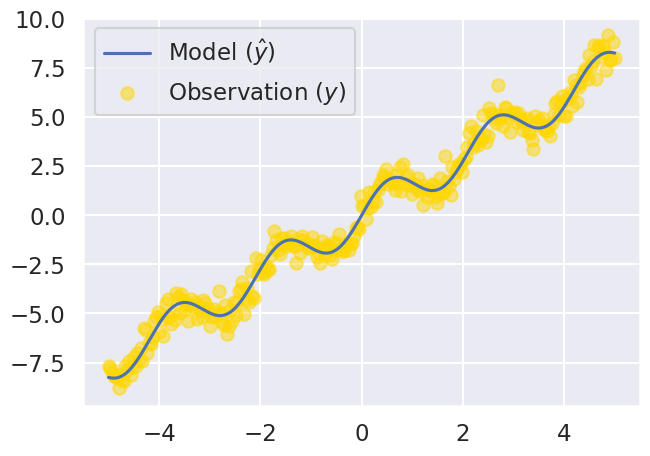

In [266]:
x, y = df['x'], df['y']
y_pred = sin_model(x, theta_est)

plt.plot(x, y_pred, label='Model ($\hat{y}$)')
plt.scatter(x, y, alpha=0.5, label='Observation ($y$)', color='gold')
plt.legend();

<br/>
<hr style="border: 1px solid #fdb515;" />

## Visualizing Loss (Extra)

Let's visualize our loss functions and gain some insight as to how gradient descent optimizes our model parameters.

In the previous plot we saw the loss decrease with each iteration. In this part, we'll see the trajectory of the algorithm as it travels the loss surface. Run the following cells to see a visualization of this trajectory. 

In [267]:
thetas = np.array(thetas).squeeze()
loss = np.array(loss)
thetas

array([[0.        , 0.        ],
       [2.60105745, 2.60105745],
       [0.90342728, 2.59100602],
       [2.05633644, 2.9631291 ],
       [1.15892347, 2.86687431],
       [1.79388042, 3.07275573],
       [1.32157494, 3.00146569],
       [1.64954491, 3.02910866],
       [1.42325294, 2.98820303],
       [1.58295041, 3.01033846],
       [1.47097255, 2.98926519],
       [1.55040965, 3.0017442 ],
       [1.49439132, 2.99135194],
       [1.5341564 , 2.99797824],
       [1.50603995, 2.99286671],
       [1.52598919, 2.99628665],
       [1.51186655, 2.99375531],
       [1.52188208, 2.99549617],
       [1.51478773, 2.99423497],
       [1.51981739, 2.99511516]])

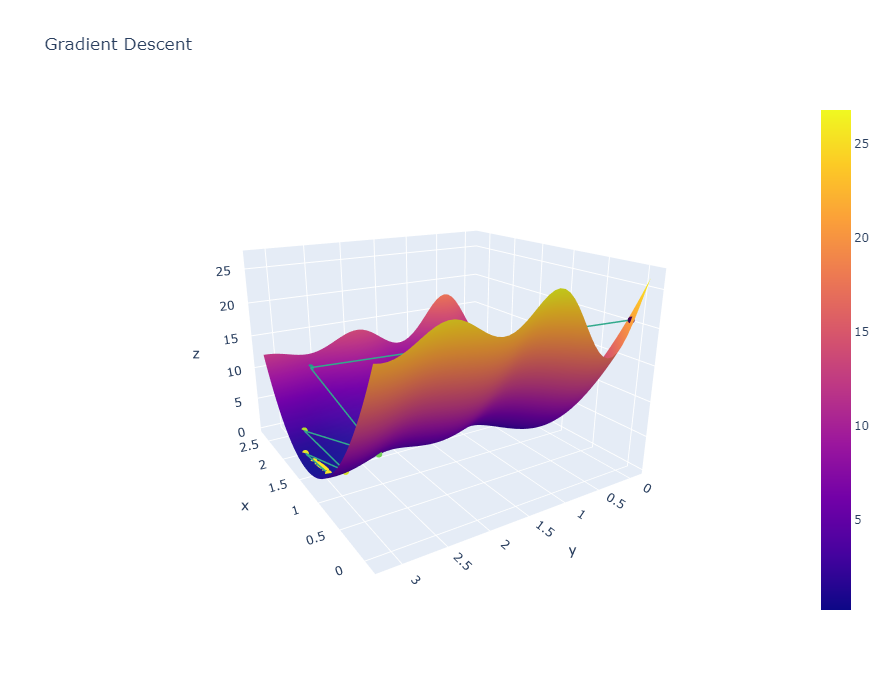

In [268]:
# Run me to see a 3D plot (gradient descent with static alpha)
from lab7_utils import plot_3d
plot_3d(thetas[:, 0], thetas[:, 1], loss, mean_squared_error, sin_model, x, y)

In [269]:
import plotly
import plotly.graph_objs as go

In [270]:
def contour_plot(title, theta_history, loss_function, model, x, y):
    """
    The function takes the following as argument:
        theta_history: a (N, 2) array of theta history
        loss: a list or array of loss value
        loss_function: for example, l2_loss
        model: for example, sin_model
        x: the original x input
        y: the original y output
    """
    theta_1_series = theta_history[:,0] # a list or array of theta_1 value
    theta_2_series = theta_history[:,1] # a list or array of theta_2 value

    ## In the following block of code, we generate the z value
    ## across a 2D grid
    theta1_s = np.linspace(np.min(theta_1_series) - 0.1, np.max(theta_1_series) + 0.1)
    theta2_s = np.linspace(np.min(theta_2_series) - 0.1, np.max(theta_2_series) + 0.1)

    x_s, y_s = np.meshgrid(theta1_s, theta2_s)
    data = np.stack([x_s.flatten(), y_s.flatten()]).T
    ls = []
    for theta1, theta2 in data:
        l = loss_function(model(x, np.array([theta1, theta2])), y)
        ls.append(l)
    z = np.array(ls).reshape(50, 50)
    
    # Create trace of theta point
    # Create the contour 
    theta_points = go.Scatter(name="theta Values", 
                              x=theta_1_series, 
                              y=theta_2_series,
                              mode="lines+markers")
    lr_loss_contours = go.Contour(x=theta1_s, 
                                  y=theta2_s, 
                                  z=z, 
                                  colorscale='Viridis', reversescale=True)

    plotly.offline.iplot(go.Figure(data=[lr_loss_contours, theta_points], layout={'title': title}))

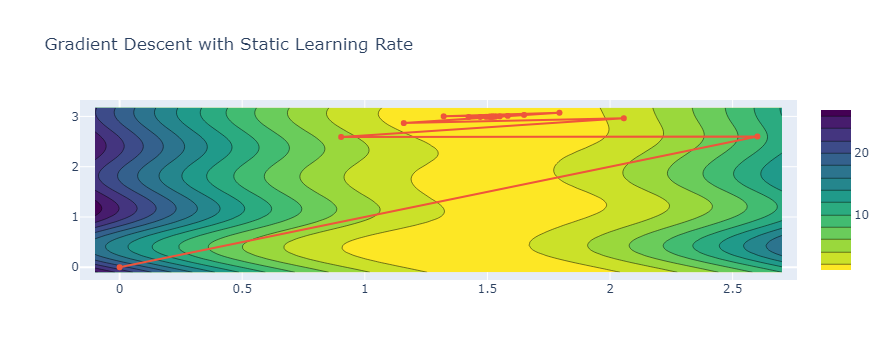

In [271]:
contour_plot('Gradient Descent with Static Learning Rate', thetas, mean_squared_error, sin_model, df["x"], df["y"])

As we can see, gradient descent is able to navigate even this fairly complex loss space and find a nice minimum.

# Congratulations! You finished the lab!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [272]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...

Your submission received the following results when run against available test cases:

    q1a results: All test cases passed!

    q2 results: All test cases passed!

    q3b results: All test cases passed!

    q4a results: All test cases passed!

    q4b results:
        q4b - 1 result:
            Trying:
                (np.round(thetas_used[1][0],8)) == 2.60105745 and (np.round(thetas_used[1][1],8)) == 2.60105745
            Expecting:
                True
            **********************************************************************
            Line 1, in q4b 0
            Failed example:
                (np.round(thetas_used[1][0],8)) == 2.60105745 and (np.round(thetas_used[1][1],8)) == 2.60105745
            Exception raised:
                Traceback (most recent call last):
                  File "/srv/conda/envs/notebook/lib/python3.9/doctest.py", line 1336, in __run
                    exec(compile(example.source, fi